In [99]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [100]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # Define the layers of the generator
    self.fc1 = nn.Linear(latent_dim, 256) # Input dimension is latent_dim (random noise vector)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, 784) # Output dimension is 784 (28x28 flattened image)

  def forward(self, x):
    # Forward pass of the generator
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.tanh(self.fc4(x)) # Use tanh activation for the output layer
    return x

In [101]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Define the layers of the discriminator
    self.fc1 = nn.Linear(784, 1024) # Input dimension is 784 (28x28 flattened image)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1) # Output dimension is 1 (probability)

  def forward(self, x):
    # Forward pass of the discriminator
    x = torch.relu(self.fc1(x)) # Use relu activation for hidden layers
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x)) # Use sigmoid activation for the output layer
    return x

In [102]:
# Define hyperparameters
batch_size = 100 # Number of images per batch
latent_dim = 20 # Dimension of the random noise vector
epochs = 20 # Number of training epochs

In [103]:
# Create a transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

In [104]:
# Download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# Create train and test dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [105]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [106]:
# Create an instance of the generator model
generator = Generator().to(device)

# Create an instance of the discriminator model
discriminator = Discriminator().to(device)

In [107]:
# Define the loss function (binary cross entropy)
criterion = nn.BCELoss()

# Define the optimizers for both models (Adam)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

In [108]:
# Training loop
for epoch in range(epochs):
  # Initialize the losses for both models
  G_loss = 0
  D_loss = 0
  # Loop over the train batches
  for batch_idx, (x, _) in enumerate(train_loader):
    # Move the input data to the device
    x = x.to(device)
    # Reshape the input images into vectors of size 784
    x = x.view(-1, 784)
    # Get the batch size (may be different for the last batch)
    b_size = x.size(0)

    # Train the discriminator
    # Zero the gradients of the discriminator
    optimizer_D.zero_grad()
    # Generate random noise vectors
    z = torch.randn(b_size, latent_dim).to(device)
    # Generate fake images from the noise vectors using the generator
    fake_x = generator(z)
    # Get the discriminator outputs for the real and fake images
    real_out = discriminator(x)
    fake_out = discriminator(fake_x.detach()) # Detach the fake images from the computation graph
    # Compute the discriminator loss using the binary cross entropy
    real_loss = criterion(real_out, torch.ones(b_size, 1).to(device)) # The real images should have label 1
    fake_loss = criterion(fake_out, torch.zeros(b_size, 1).to(device)) # The fake images should have label 0
    D_loss = real_loss + fake_loss
    # Backward pass of the discriminator
    D_loss.backward()
    # Update the discriminator parameters
    optimizer_D.step()

    # Train the generator
    # Zero the gradients of the generator
    optimizer_G.zero_grad()
    # Generate random noise vectors
    z = torch.randn(b_size, latent_dim).to(device)
    # Generate fake images from the noise vectors using the generator
    fake_x = generator(z)
    # Get the discriminator output for the fake images
    fake_out = discriminator(fake_x) # Do not detach the fake images from the computation graph
    # Compute the generator loss using the binary cross entropy
    G_loss = criterion(fake_out, torch.ones(b_size, 1).to(device)) # The generator wants to make the fake images have label 1
    # Backward pass of the generator
    G_loss.backward()
    # Update the generator parameters
    optimizer_G.step()

  # Print the losses per epoch
  print(f"Epoch {epoch+1}, Generator loss: {G_loss.item():.4f}, Discriminator loss: {D_loss.item():.4f}")

Epoch 1, Generator loss: 2.2015, Discriminator loss: 0.6318
Epoch 2, Generator loss: 1.9173, Discriminator loss: 0.6551
Epoch 3, Generator loss: 3.5774, Discriminator loss: 0.4214
Epoch 4, Generator loss: 4.5114, Discriminator loss: 0.2644
Epoch 5, Generator loss: 5.9031, Discriminator loss: 0.1351
Epoch 6, Generator loss: 3.3363, Discriminator loss: 0.2934
Epoch 7, Generator loss: 4.7490, Discriminator loss: 0.3606
Epoch 8, Generator loss: 4.0189, Discriminator loss: 0.2027
Epoch 9, Generator loss: 4.2651, Discriminator loss: 0.2172
Epoch 10, Generator loss: 4.0049, Discriminator loss: 0.1897
Epoch 11, Generator loss: 5.0480, Discriminator loss: 0.1570
Epoch 12, Generator loss: 4.6150, Discriminator loss: 0.1611
Epoch 13, Generator loss: 5.2244, Discriminator loss: 0.0885
Epoch 14, Generator loss: 4.9625, Discriminator loss: 0.1108
Epoch 15, Generator loss: 4.4384, Discriminator loss: 0.1812
Epoch 16, Generator loss: 5.8626, Discriminator loss: 0.1160
Epoch 17, Generator loss: 4.4201,

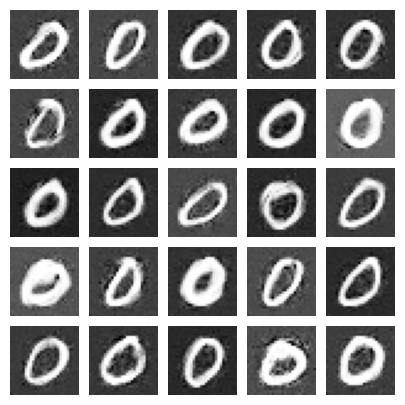

In [109]:
# Generate some new images from random noise vectors
with torch.no_grad():
  # Sample random noise vectors from a standard normal distribution
  z = torch.randn(25, latent_dim).to(device)
  # Generate fake images from the noise vectors using the generator
  fake_x = generator(z).cpu()
  # Reshape them into 28x28 images
  fake_x = fake_x.view(-1, 28, 28)
  # Plot them in a grid
  fig = plt.figure(figsize=(5,5))
  grid = ImageGrid(fig, 111, nrows_ncols=(5,5), axes_pad=0.1)
  for ax, im in zip(grid, fake_x):
    ax.imshow(im.numpy(), cmap='gray')
    ax.axis('off')
  plt.show()